In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
%matplotlib inline

In [ ]:
"""
Quora uses a combination of machine learning (ML) algorithms and moderation to ensure high-quality content on the site. High answer quality has helped Quora distinguish itself from other Q&A sites on the web.  

Your task will be to devise a classifier that is able to tell good answers from bad answers, as well as humans can.  A good answer is denoted by a +1 in our system, and a bad answer is denoted by a -1.

Input format (read from STDIN):
The first line contains N, M. N = Number of training data records, M = number of parameters. Followed by N lines containing records of training data. Then one integer q, q = number of records to be classified, followed by q lines of query data

Training data corresponds to the following format:
<answer-identifier> <+1 or -1> (<feature-index>:<feature-value>)*

Query data corresponds to the following format:
<answer-identifier> (<feature-index>:<feature-value>)*

The answer identifier  is an alphanumeric string of no more than 10 chars.  Each identifier is guaranteed unique.  All feature values are doubles.
0 < M < 100
0 < N < 50,000
0 < q < 5,000

This data is completely anonymized and extracted from real production data, and thus will not include the raw form of the
answers. We, however, have extracted as many features as we think are useful, and you can decide which features make sense to be included in your final algorithm. The actual labeling of a good answer and bad answer is done organically on our site, through human moderators.

Output format (write to STDOUT):
For each query, you should output q lines to stdout, representing the decision made by your classifier, whether each answer is good or not:

<answer-identifier> <+1 or -1>

You are given a relative large sample input dataset offline with its corresponding output to finetune your program with your ML libraries.  It can be downloaded here: http://qsf.cf.quoracdn.net/Quora...

Scoring
Only one very large test dataset will be given for this problem online as input to your program for scoring.  This input data set will not be revealed to you.

Output for every classification is awarded points separately. The score for this problem will be the sum of points for each correct classification. To prevent naive solution credit (outputting all +1s, for example), points are awarded only after X correct classifications, where X is number of +1 answers or -1 answers (whichever is greater).

Timing
Your program should complete in minutes. Try to achieve as high an accuracy as possible with this constraint in mind.
"""

In [3]:
# Preparing the input data for processing

with open('input00.txt', 'r') as fh:
    first_line = fh.readline()

first_line = [int(s_temp) for s_temp in first_line.strip().split(' ')]

df_input = pd.read_table('input00.txt', sep=' |:', engine='python', 
                         skiprows=[0], nrows=first_line[0]-1, header=None)

df_input.drop([df_input.columns[i] for i in range(2,len(df_input.columns),2)], axis=1, inplace=True)

df_test = pd.read_table('input00.txt', sep=' |:', engine='python', 
                       skiprows=first_line[0]+2, header=None)

df_test.drop([df_test.columns[i] for i in range(1,len(df_test.columns),2)], axis=1, inplace=True)

print(df_input.tail())
print(df_test.head())



         0   1              3         5   7         9         11         13  \
4494  Ehbr3  -1   158475597491  0.000000   1  5.652489  4.369448  72.000000   
4495  ywqvs  -1  7803682824686  1.389855   1  3.258097  3.044522  91.666667   
4496  qse8U  -1   781476116673  1.828627   1  6.684612  6.107023   0.000000   
4497  xg7b3  -1    31363070876  0.000000   1  1.386294  2.639057   0.000000   
4498  xSiLk  -1   244858151308  1.333277   1  1.945910  1.386294   0.000000   

       15   17 ...   29  31  33  35  37  39  41        43   45   47  
4494  0.0  0.0 ...    0   0   1   0   0   0  10  4.499810  0.0  0.0  
4495  0.0  0.0 ...    0   0   1   0   0   0   2  1.791759  0.0  0.0  
4496  0.0  0.0 ...    0   0   0   0   0   0   4  2.197225  0.0  0.0  
4497  0.0  0.0 ...    0   0   0   0   0   0   0  1.386294  0.0  0.0  
4498  0.0  0.0 ...    0   0   0   0   1   0  10  3.178054  0.0  0.0  

[5 rows x 25 columns]
      0             2         4   6         8         10         12   14   16  \
0

In [4]:
print("Any duplicates in input data: ", any(df_input.duplicated()))
print("Any duplicates in test data: ", any(df_test.duplicated()))

#print(df_input.isnull())

Any duplicates in input data:  False
Any duplicates in test data:  False


In [5]:
df_input['Result'] = df_input[1].replace(-1,0)
df_input.drop(1, axis=1, inplace=True)

df_input.columns = range(len(df_input.columns))
df_test.columns = range(len(df_test.columns))

print(df_input.tail())
print(df_test.tail())

         0              1         2   3         4         5          6    7   \
4494  Ehbr3   158475597491  0.000000   1  5.652489  4.369448  72.000000  0.0   
4495  ywqvs  7803682824686  1.389855   1  3.258097  3.044522  91.666667  0.0   
4496  qse8U   781476116673  1.828627   1  6.684612  6.107023   0.000000  0.0   
4497  xg7b3    31363070876  0.000000   1  1.386294  2.639057   0.000000  0.0   
4498  xSiLk   244858151308  1.333277   1  1.945910  1.386294   0.000000  0.0   

       8   9  ...  15  16  17  18  19  20        21   22   23  24  
4494  0.0   0 ...   0   1   0   0   0  10  4.499810  0.0  0.0   0  
4495  0.0   0 ...   0   1   0   0   0   2  1.791759  0.0  0.0   0  
4496  0.0   0 ...   0   0   0   0   0   4  2.197225  0.0  0.0   0  
4497  0.0   1 ...   0   0   0   0   0   0  1.386294  0.0  0.0   0  
4498  0.0   0 ...   0   0   0   1   0  10  3.178054  0.0  0.0   0  

[5 rows x 25 columns]
        0              1         2   3         4         5    6    7    8   \
495  VBFpQ

In [6]:
df_input.describe()
# Features 22 and 23 are zeros for all rows!

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
count,4.499000e+03,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,...,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.0,4499.0,4499.000000
mean,2.966161e+12,1.573233,0.926650,3.041713,3.237342,19.157249,0.130502,0.241558,0.114248,0.069571,...,0.139364,0.507891,0.245388,0.303623,0.000222,7.103134,2.616166,0.0,0.0,0.499889
std,5.144219e+12,1.319961,0.260739,1.750163,1.782595,33.318629,0.821342,1.084865,0.409230,0.254451,...,0.346365,0.499993,0.430365,1.044928,0.014909,15.947545,1.122178,0.0,0.0,0.500056
min,7.719020e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,7.536168e+09,0.000000,1.000000,1.791759,1.945910,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.791759,0.0,0.0,0.000000
50%,4.357655e+11,1.708538,1.000000,3.295837,3.367296,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.397895,0.0,0.0,0.000000
75%,3.493756e+12,2.222850,1.000000,4.317488,4.510860,41.547619,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000,3.135494,0.0,0.0,1.000000
max,3.530833e+13,7.947971,1.000000,9.219201,9.999979,100.000000,20.154320,16.662929,7.000000,1.000000,...,1.000000,1.000000,1.000000,47.000000,1.000000,269.000000,7.309212,0.0,0.0,1.000000


In [7]:
# Look for which features might be categorical or ordinal based on their unique values in the input dataset
for i in range(len(df_input.columns)):
    print("i:",i, df_input[i].unique())

i: 0 ['Nt8FJ' 'VCaTF' 'gParY' ..., 'qse8U' 'xg7b3' 'xSiLk']
i: 1 [12087620705283   282114466020      173284955 ...,   781476116673
    31363070876   244858151308]
i: 2 [ 4.797982  3.151926  1.785813 ...,  1.389855  1.828627  1.333277]
i: 3 [1 0]
i: 4 [ 4.990433  3.73767   1.791759  3.091042  4.836282  4.488636  0.693147
  4.744932  3.135494  2.772589  4.672829  4.663439  0.        6.265301
  4.219508  4.189655  3.637586  3.951244  4.304065  5.117994  4.418841
  3.526361  3.555348  4.85203   1.609438  4.317488  4.442651  4.330733
  3.465736  3.871201  4.905275  4.143135  6.122493  5.796058  3.663562
  4.276666  3.332205  1.386294  2.564949  3.713572  8.557759  5.874931
  5.802118  4.691348  3.988984  3.7612    4.51086   4.465908  2.397895
  2.079442  5.278115  2.484907  3.258097  4.997212  4.158883  5.407172
  4.624973  3.610918  3.970292  3.89182   4.60517   3.401197  3.583519
  4.795791  2.944439  1.098612  2.995732  3.850148  4.290459  4.770685
  4.934474  2.197225  4.49981   4.56434

i: 9 [0 1 3 2 4 7 6]
i: 10 [0 1]
i: 11 [ 3.850148  2.564949  4.26268   4.804021  4.521789  2.70805   4.394449
  3.218876  5.327876  3.555348  5.283204  3.7612    2.397895  3.091042
  1.098612  2.890372  2.302585  3.871201  4.762174  3.178054  5.123964
  2.484907  3.465736  6.955593  3.78419   3.044522  3.73767   3.526361
  4.564348  3.713572  1.94591   4.553877  4.174387  3.806662  5.583496
  3.332205  4.248495  3.828641  3.295837  1.609438  4.727388  4.127134
  5.655992  2.197225  4.382027  3.912023  1.386294  3.610918  2.079442
  3.258097  4.75359   3.663562  3.433987  2.833213  5.529429  4.615121
  4.304065  4.060443  5.01728   1.791759  2.772589  0.693147  4.574711
  4.110874  6.363028  5.673323  3.401197  4.990433  4.077537  5.849325
  4.143135  5.293305  5.068904  6.833032  4.787492  3.931826  2.944439
  3.951244  4.779123  5.036953  3.988984  4.795791  3.583519  4.59512
  4.919981  2.995732  4.356709  4.890349  4.317488  4.276666  4.234107
  5.075174  3.496508  4.955827  5.64544

In [8]:
# Look for which features might be categorical or ordinal based on their unique values in the test dataset
for i in range(len(df_test.columns)):
    print("i:",i, df_test[i].unique())

i: 0 ['3rCWr' 'snInN' 'ibfT7' 'IcbKR' 'SIXmF' 'dLCdh' 'ziFJ8' '1WtTD' '9uIKh'
 'df4Mc' '3nxpY' 'aesmq' 'MyTDz' 'TDMhx' 'Y0rW3' 'KCcKf' '2cz5M' 'kqIJj'
 'C1Sg2' 'VAmIt' 'ku9j1' 'TjHRV' 'sq8Xj' 'uKzm4' '3at4H' '8nXGS' '4x8ij'
 'PeMnA' 'UUPpU' 'HQ4lZ' 'lEv01' 'XCY52' 'FNoY7' 'JJbco' 'PHQ7z' 'Xejsj'
 'A4IsT' '7cU9R' '8mSRL' 'jRMuo' 'dljxu' 'wZyoj' 'us2ca' 'EVenw' 'QLseT'
 'lanI5' 'RF9di' '3e6Aa' 'W5mvO' 'LkKbu' 'gbus8' 'LN4W4' '9FNA4' 'rd3qM'
 'pV8eI' '5wnO7' '03KFY' 'i25BS' 'AziH8' 'YyCpz' 'qLfPb' 'CJBeL' 'EaAPx'
 'sQDFf' 'CELfn' 'Ac6Hy' 'ULryN' 'qCBAx' 'Hoz2c' '8kLbb' 'KAWwb' 'lNMTe'
 'MzTHU' 'Sq8XV' 's8ZUG' 'lDcDx' 'xZoGD' 'vHLAR' 'Ag2kt' 'baqkE' 'Hsbs2'
 'BlvEz' 'CJqsS' 'vbzII' 'R16fw' 'IxBjS' 'yJl2b' 'RXdcX' 'T7uzV' 'ccZGw'
 'f9xFZ' 'dO9iE' '2TaN2' 'a1XoY' '1xXiG' 'a8kZK' 'mXe41' '8NfbF' 'Sqdti'
 'gnCsH' 'YGNBE' 'zOA3j' 'b3Cm5' 'Wjo2X' 'IcuwU' 'FyieE' '5OUK8' 'SjCvq'
 'kKVUa' 'CEVSg' 'F2MAp' 'hOKPP' 'X22r3' 'kDxwQ' 's42QM' 'Olrdu' 'P6Fag'
 'IHvly' '5bWYy' '5zeok' '6Z4hF' '1RjNM' 'yc6u

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CAC9F0630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000019CAC7F1A58>]], dtype=object)

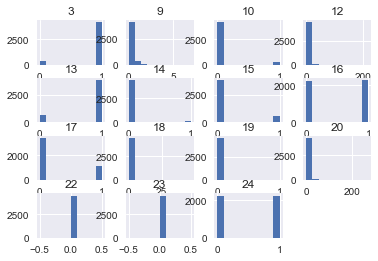

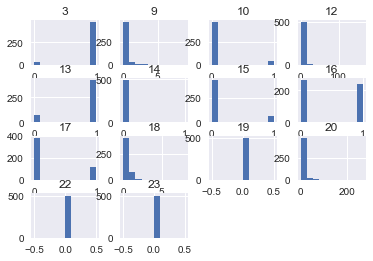

In [9]:
# The nonint columns below are likely to be categorical or ordinal based on their unique values, we can verify further by
# checking their histograms
nonint_data1 = [3, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24]
nonint_data2 = [3, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23]
pd.options.mode.chained_assignment = None
df1 = df_input[nonint_data1]
df2 = df_test[nonint_data2]

df1.hist() # This is the input data
df2.hist() # This is the test data

# This also shows features 22 and 23 are only zeros

In [10]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    #plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    

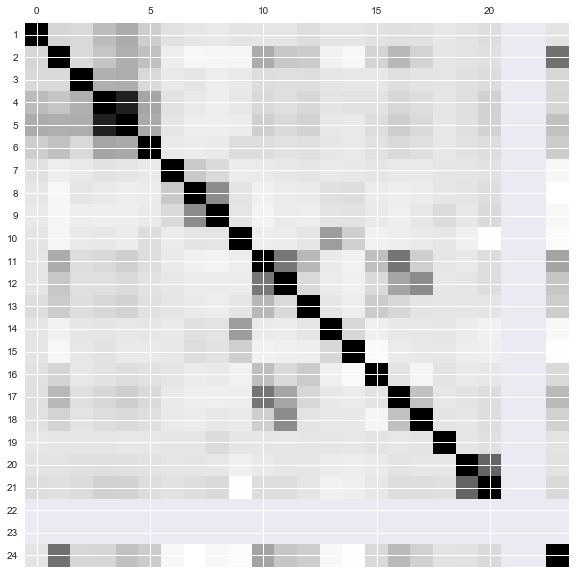

In [11]:
"""Plot the correlation matrix to examine correlations between each pair of features and the target Result.

"""
plot_corr(df_input)

In [12]:
corr_data = df_input.corr()
print(corr_data[24].sort_values(ascending=True))

# This shows features which are correlated with the Result. Most features demonstrate some correlation except features 22 and 23 
# as expected. Also, groups of correlated features (e.g. 4,5,6; 8,9; 11,12; and 20,21) can be viewed.

# Feature 8 shows the highest negative correlation and feature 2 has the highest positive correlation. Feature 1 shows the weakest
# correlation with the results.

8    -0.218766
15   -0.208495
10   -0.184275
14   -0.154467
7    -0.140094
9    -0.136826
1     0.009844
19    0.014914
20    0.028410
21    0.071893
16    0.085144
3     0.098835
4     0.100448
18    0.125580
13    0.147535
6     0.154040
12    0.187522
5     0.217992
17    0.249094
11    0.338155
2     0.551451
24    1.000000
22         NaN
23         NaN
Name: 24, dtype: float64


In [13]:
# We can run feature scaling on the columns that are not categorical or ordinal as identified previously
scaler1 = preprocessing.StandardScaler()

# Use standard scaler to center all the integer type features around 0 and have variance in the same order.
df_input[[1,2,4,5,6,7,8,11,21]] = scaler1.fit_transform(df_input[[1,2,4,5,6,7,8,11,21]].as_matrix())
# Transform the final test data with the same scaler
df_test[[1,2,4,5,6,7,8,11,21]] = scaler1.transform(df_test[[1,2,4,5,6,7,8,11,21]].as_matrix())
df_test.describe()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.00000,500.000000,500.000000,500.000000,500.000000,500.0,500.000000,500.000000,500.0,500.0
mean,0.011786,-0.050877,0.938000,0.013880,-0.019154,-0.040351,-0.045284,-0.034531,0.134000,0.072000,...,0.02000,0.134000,0.476000,0.240000,0.284000,0.0,7.854000,0.066781,0.0,0.0
std,0.987729,0.936348,0.241397,0.954005,0.961424,0.973622,0.657685,0.899668,0.600638,0.258747,...,0.14014,0.340993,0.499924,0.427511,0.792844,0.0,17.472242,1.034111,0.0,0.0
min,-0.576665,-1.192011,0.000000,-1.738152,-1.816285,-0.575035,-0.158907,-0.222687,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-1.713840,0.0,0.0
25%,-0.574122,-1.192011,1.000000,-0.714272,-0.649631,-0.575035,-0.158907,-0.222687,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,-0.734731,0.0,0.0
50%,-0.474846,0.088339,1.000000,0.165999,0.053222,-0.575035,-0.158907,-0.222687,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,-0.045646,0.0,0.0
75%,0.173454,0.382987,1.000000,0.744066,0.662871,-0.575035,-0.158907,-0.222687,0.000000,0.000000,...,0.00000,0.000000,1.000000,0.000000,0.000000,0.0,7.000000,0.537149,0.0,0.0
max,6.469897,3.441029,1.000000,2.314344,2.458701,2.426623,8.703398,7.461248,9.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,8.000000,0.0,269.000000,4.182552,0.0,0.0


In [14]:
# Setting up the training (70%) and test (30%) sets
np.random.seed(7)
msk1 = np.random.rand(len(df_input)) < 0.7
train = df_input[msk1]
test = df_input[~msk1]

In [15]:
df_input.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Nt8FJ,1.773345,2.443336,1,1.113574,1.826135,1.826291,-0.158907,-0.222687,0,...,0,1,1,0,0,14,1.816129,0.0,0.0,1
1,VCaTF,-0.521818,1.196148,1,0.397697,0.367190,1.916341,-0.158907,-0.222687,1,...,0,1,0,0,0,2,0.244379,0.0,0.0,1
2,gParY,-0.576631,0.161068,1,-0.714272,-0.724548,-0.575035,-0.158907,-0.222687,0,...,0,1,0,0,0,6,0.910313,0.0,0.0,1
3,DtWDw,0.338781,0.622630,1,0.028189,-0.194665,-0.575035,-0.158907,-0.222687,0,...,0,1,1,0,0,5,0.139408,0.0,0.0,1
4,4hUov,-0.576381,0.325567,1,1.025486,0.517023,-0.575035,-0.158907,-0.222687,0,...,0,1,0,0,0,7,-0.194528,0.0,0.0,1


In [16]:
#Exclude ID, Results and features 22,23 from feature columns
features = train.columns[1:-3]

# Start with logistic regression since it is the simplest to interpret

# Initialize logistic regression model
log_model = LogisticRegression()

# Train the model
log_model.fit(X = train[features] ,
              y = train[24])

# Check trained model intercept
print("Trained model intercept: ", log_model.intercept_)

Trained model intercept:  [-0.27216195]


In [17]:
"""Using Recursive Feature Extraction to rank the most important features in the model"""
rfe = feature_selection.RFE(log_model, 1)
rfe = rfe.fit(train[features], train[24])

print ("Features sorted by their rank:")

tmp_lst = list(map(lambda x: round(x, 4), rfe.ranking_))
Feature_coeff = pd.DataFrame({"Feature_Rank":tmp_lst, "Features":features, "Model_Coeff":log_model.coef_[0]})
Feature_coeff_sorted = Feature_coeff.sort_values('Feature_Rank')
print(Feature_coeff_sorted)

Features sorted by their rank:
    Feature_Rank  Features  Model_Coeff
13             1        14    -1.918958
1              2         2     1.394591
7              3         8    -1.362661
14             4        15    -1.079246
9              5        10    -0.963604
4              6         5     0.934325
3              7         4    -0.799084
10             8        11     0.470987
6              9         7    -0.501927
2             10         3     0.370864
17            11        18     0.234534
18            12        19     0.257846
5             13         6     0.271293
0             14         1    -0.249227
15            15        16    -0.211811
16            16        17     0.103250
20            17        21     0.087227
12            18        13     0.065604
8             19         9    -0.051300
11            20        12     0.020996
19            21        20    -0.000277


In [18]:
# Make predictions on the training set
preds = log_model.predict(X= train[features])

Train_Results = pd.DataFrame({"ID":train[0],
                           "ActualOutcome":train[24],
                           "Predicted":preds})

# Generate table of predictions vs actual
target_names = ['class 0', 'class 1']
print(classification_report(preds, train[24], target_names=target_names))
# Logistic regression does reasonably well with accuracy of 0.82

             precision    recall  f1-score   support

    class 0       0.81      0.82      0.82      1559
    class 1       0.83      0.81      0.82      1597

avg / total       0.82      0.82      0.82      3156



In [19]:
# Consider other model options and evaluate metrics using k-folds cross-validation
num_folds = 10
num_instances = len(train[features])
seed = 7
scoring = 'accuracy'
models = []

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('ERF', ExtraTreesClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
 
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train[features], train[24], cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.815904 (0.018041)
KNN: 0.753796 (0.018022)
CART: 0.750313 (0.023454)
NB: 0.760773 (0.034675)
SVM: 0.807669 (0.018199)
RF: 0.822241 (0.020489)
ERF: 0.793096 (0.013094)
AB: 0.838413 (0.021795)
GB: 0.846641 (0.019613)


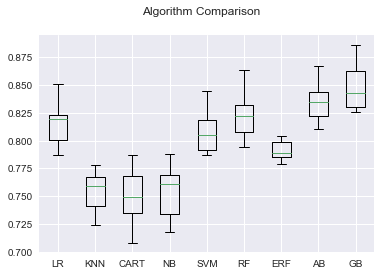

In [20]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# This shows Logistic regression is nearly on par with Random Forest, although adaboost and gradient boost have a higher accuracy
# Select Gradient Boost 

[ 0.98412698  0.91556857  0.89302191  0.87886229  0.87541607]
[ 0.82097069  0.8314351   0.83935622  0.84347326  0.84410607]


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

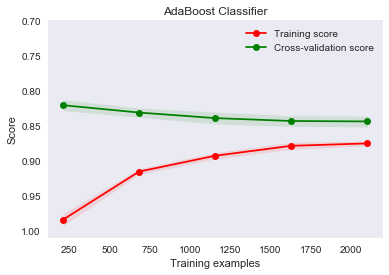

In [21]:
#Plot learning curves using sklearn's default learning curve plotting function

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    print(train_scores_mean)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(test_scores_mean)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "AdaBoost Classifier"

plot_learning_curve(GradientBoostingClassifier(n_estimators = 91, max_features='sqrt'), title, train[features], train[24], ylim=(1.01, 0.7))  

# Learning curve shows we are not in high bias or high variance regimes and the model is making reasonable predictions

In [51]:
# Use GridSearchCV to find best parameters and score
parameters = {'max_features':('auto', 'log2'), 'n_estimators':[70, 80, 90, 100], 'subsample':[0.01,0.1, 0.3, 0.7, 1.0]}
gradboost = GradientBoostingClassifier()
clf = GridSearchCV(gradboost, parameters)
clf.fit(train[features], train[24])
#sorted(clf.cv_results_.keys())
#clf.cv_results_.values()
clf.get_params(deep=True)
print(clf.score(train[features], train[24]))
print(clf.best_params_)

0.867553865653
{'max_features': 'log2', 'n_estimators': 100, 'subsample': 0.7}


In [52]:
# Compare with Adaboost
parameters = {'n_estimators':[70, 80, 90, 100], 'learning_rate':[0.01,0.1, 0.3, 0.7, 1.0]}
adaboost = AdaBoostClassifier()
clf = GridSearchCV(adaboost, parameters)
clf.fit(train[features], train[24])
#sorted(clf.cv_results_.keys())
#clf.cv_results_.values()
clf.get_params(deep=True)
print(clf.score(train[features], train[24]))
print(clf.best_params_)

0.858998732573
{'learning_rate': 1.0, 'n_estimators': 100}


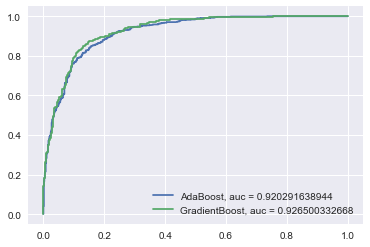

In [25]:
# Compare the Adaboost model with Gradient Boost

from sklearn import metrics
import pandas as pd
from ggplot import *

plt.figure(0).clf()
AdaBoost = AdaBoostClassifier()

AdaBoost.fit(X = train[features] ,
              y = train[24])

preds = AdaBoost.predict_proba(X= test[features])[:,1]
ytest = test[24]
fpr, tpr, _ = metrics.roc_curve(ytest, preds)
auc = metrics.roc_auc_score(ytest, preds)
plt.plot(fpr, tpr, label = "AdaBoost, auc = "+ str(auc))    

# Initialize GradientBoost model
GradientBoost = GradientBoostingClassifier(n_estimators=100, max_features='sqrt', subsample=1.0)

# Train the model
GradientBoost.fit(X = train[features] ,
              y = train[24])
preds = GradientBoost.predict(X= train[features])

preds2 = GradientBoost.predict_proba(X= test[features])[:,1]
predstest = GradientBoost.predict(X=test[features])
ytest = test[24]
fpr, tpr, _ = metrics.roc_curve(ytest, preds2)
auc = metrics.roc_auc_score(ytest, preds2)
plt.plot(fpr, tpr, label="GradientBoost, auc = "+ str(auc))    


plt.legend(loc=0)

# Gradient boost outperforms just slightly in terms of lift

In [26]:
# Confusion matrix for gradientboost classifier
print(confusion_matrix(ytest, predstest))

[[571  97]
 [ 92 583]]


In [27]:
target_names = ['class 0', 'class 1']
print(classification_report(ytest, predstest, target_names=target_names))
# Let's fit the final model with Gradient Boost

             precision    recall  f1-score   support

    class 0       0.86      0.85      0.86       668
    class 1       0.86      0.86      0.86       675

avg / total       0.86      0.86      0.86      1343



In [28]:
# Create final test data for submission
df_test_features = df_test.iloc[:,1:-2]
print(df_test_features)

           1         2   3         4         5         6         7         8   \
0   -0.568127  0.207816   1 -1.110363 -0.724548  0.454105 -0.158907 -0.222687   
1   -0.499367 -1.192011   1  1.412434  0.720629 -0.575035 -0.158907 -0.222687   
2   -0.564737 -1.192011   1  1.034485  0.480815  1.886324 -0.158907 -0.222687   
3   -0.576492  1.598823   1  1.132688  1.161877  1.526125 -0.158907 -0.222687   
4   -0.576636  0.173079   1  0.530626  0.662871 -0.575035 -0.158907 -0.222687   
5   -0.576568  0.130204   1  1.093799  1.874952 -0.575035 -0.158907 -0.222687   
6   -0.576626 -1.192011   1 -0.714272 -0.296955  1.646192 -0.158907 -0.222687   
7   -0.556600 -0.210288   1  1.179582  0.517023 -0.575035 -0.158907  3.386447   
8    3.887173  0.619932   1  0.793788  0.720629  1.766258 -0.158907 -0.222687   
9    0.901820  0.418316   1  0.077911 -0.422148 -0.575035  1.920567 -0.222687   
10  -0.576656 -0.299571   1 -0.626184 -0.811033 -0.575035 -0.158907 -0.222687   
11  -0.565292  0.196225   1 

In [29]:
msk_new = np.random.rand(len(df_test)) < 1.0
train2 = df_test[msk_new]

In [30]:
train2
featuresnew = train2.columns[1:-2]
print(train2[featuresnew])

           1         2   3         4         5         6         7         8   \
0   -0.568127  0.207816   1 -1.110363 -0.724548  0.454105 -0.158907 -0.222687   
1   -0.499367 -1.192011   1  1.412434  0.720629 -0.575035 -0.158907 -0.222687   
2   -0.564737 -1.192011   1  1.034485  0.480815  1.886324 -0.158907 -0.222687   
3   -0.576492  1.598823   1  1.132688  1.161877  1.526125 -0.158907 -0.222687   
4   -0.576636  0.173079   1  0.530626  0.662871 -0.575035 -0.158907 -0.222687   
5   -0.576568  0.130204   1  1.093799  1.874952 -0.575035 -0.158907 -0.222687   
6   -0.576626 -1.192011   1 -0.714272 -0.296955  1.646192 -0.158907 -0.222687   
7   -0.556600 -0.210288   1  1.179582  0.517023 -0.575035 -0.158907  3.386447   
8    3.887173  0.619932   1  0.793788  0.720629  1.766258 -0.158907 -0.222687   
9    0.901820  0.418316   1  0.077911 -0.422148 -0.575035  1.920567 -0.222687   
10  -0.576656 -0.299571   1 -0.626184 -0.811033 -0.575035 -0.158907 -0.222687   
11  -0.565292  0.196225   1 

In [31]:
df_test_preds = GradientBoost.predict(X=train2[featuresnew])

In [32]:
df_test_preds

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1,

In [33]:
# Formatting output
df_test['Results'] = pd.Series(df_test_preds, index=df_test.index)
df_test['Results'] = df_test['Results'].replace(0,-1)

In [35]:
df_out = df_test[[0, 'Results']]

In [37]:
print(df_out.to_string(index=False, header=False))

3rCWr  1
snInN -1
ibfT7 -1
IcbKR  1
SIXmF  1
dLCdh  1
ziFJ8 -1
1WtTD -1
9uIKh  1
df4Mc -1
3nxpY -1
aesmq  1
MyTDz  1
TDMhx  1
Y0rW3  1
KCcKf  1
2cz5M -1
kqIJj -1
C1Sg2  1
VAmIt -1
ku9j1 -1
TjHRV  1
sq8Xj -1
uKzm4 -1
3at4H  1
8nXGS  1
4x8ij  1
PeMnA -1
UUPpU -1
HQ4lZ  1
lEv01  1
XCY52 -1
FNoY7  1
JJbco -1
PHQ7z -1
Xejsj  1
A4IsT -1
7cU9R -1
8mSRL  1
jRMuo -1
dljxu  1
wZyoj -1
us2ca  1
EVenw  1
QLseT -1
lanI5  1
RF9di  1
3e6Aa -1
W5mvO -1
LkKbu -1
gbus8 -1
LN4W4  1
9FNA4 -1
rd3qM -1
pV8eI -1
5wnO7  1
03KFY -1
i25BS  1
AziH8  1
YyCpz -1
qLfPb -1
CJBeL -1
EaAPx -1
sQDFf -1
CELfn -1
Ac6Hy -1
ULryN -1
qCBAx  1
Hoz2c -1
8kLbb -1
KAWwb  1
lNMTe  1
MzTHU  1
Sq8XV -1
s8ZUG -1
lDcDx  1
xZoGD  1
vHLAR  1
Ag2kt  1
baqkE  1
Hsbs2 -1
BlvEz -1
CJqsS -1
vbzII  1
R16fw -1
IxBjS -1
yJl2b -1
RXdcX  1
T7uzV -1
ccZGw  1
f9xFZ -1
dO9iE -1
2TaN2 -1
a1XoY -1
1xXiG -1
a8kZK  1
mXe41  1
8NfbF  1
Sqdti  1
gnCsH -1
YGNBE  1
zOA3j  1
b3Cm5  1
Wjo2X  1
IcuwU  1
FyieE  1
5OUK8  1
SjCvq -1
kKVUa  1
CEVSg  1
F2MAp -1
h